# **Regular Group Equivariant Convolution Neural Networks with pytorch and einops**


Regular Group Convolution Neural Networks are extremely simple to implement. 'Regular' represents kind of 
representation used in convolution layers. Other way that is better scalable is Steerable CNNs. we would need to work on 5,6 dimensional 
tensors, it becomes hard to keep track what different dimensions stand for. So we will use  einops for manipulating tensors in readable way

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

#### <u>**Group P4**</u>  

P4 is Discrete Rotation-Translation group. Rotations are done at ${0, 90, 180, 270}$ degrees and translations are done by elements in $\mathbb{Z}^2$. P4 can be seen as 4 copies 
of $\mathbb{Z}^{2}.$ Hence, we can describe group in 3 parameters. There are many equivalent(homomorphically) ways to describe the group

 1) $$\displaystyle P4_{1} =  \left\{ 0 , 1, 2, 3 \right\} \times \mathbb{Z}^2 $$

 * $\text{ with group operation  being} \,\, (r,x,y) . (r',x', y') = \left(r+r'\,\, \text{mod} \,\, 4 \,\,, x+x',\,\, y+y'  \right)$
 * $\text{ with inverse being } (r,x,y)^{-1} = ((4-r)\text{mod} \,\, 4, -x, -y) $
 
  <br> </br>
  
 2) $P4_{2} = \left\{ \begin{bmatrix}
    \cos(r \frac{\pi}{2}) & -\sin(r \frac{\pi}{2}) & u  \\
     \sin(r \frac{\pi}{2}) & \cos(r \frac{\pi}{2}) & v \\
     0 & 0 & 1 
    \end{bmatrix} \Big| r \in [0,1,2,3], (u,v) \in \mathbb{Z}^2 \right\}$

  *  with group operation  being matrix multiplication
  *  with inverse being matrix inverse

    
    
*claim:* $P4_{1} \cong P4_{2}$ 



Although first way of describing the group is much easier and intuitive and clearly explains cyclic shifting for rotation coordinates (this becomes crucial while implementing stuff). we will see that second way to describe the group helps in writing group action simpler




##### Group Action of P4 on $\mathbb{Z}^2$ 

P4 acts on $\mathbb{Z}^2$ in intutitive manner. Given $(r, x, y) \in $ P4 and $(x', y') \in \mathbb{Z}^2.$ Action of group can visualized as rotating $(x',y')$ by $r \frac{\pi}{2}$ around center of grid and then translating it by $(x,y).$ To write this algebrically would be better with $P4_{2}$

$ \odot : P{4}_{2} \times \mathbb{Z}^2 \rightarrow   \mathbb{Z}^2 \times \{1\} \cong \mathbb{Z}^2$


$\begin{bmatrix}
    \cos(r \frac{\pi}{2}) & -\sin(r \frac{\pi}{2}) & u  \\
     \sin(r \frac{\pi}{2}) & \cos(r \frac{\pi}{2}) & v \\
     0 & 0 & 1 
    \end{bmatrix} \odot \begin{bmatrix} u' \\ v' \end{bmatrix} = \begin{bmatrix}
    \cos(r \frac{\pi}{2}) & -\sin(r \frac{\pi}{2}) & u  \\
     \sin(r \frac{\pi}{2}) & \cos(r \frac{\pi}{2}) & v \\
     0 & 0 & 1 
    \end{bmatrix} \begin{bmatrix} u' \\ v' \\1 \end{bmatrix}$




##### Group Action of P4 on functions from  $\mathbb{Z}^2 \rightarrow \mathbb{R}^{\ell}$

Let $F(\mathbb{Z}^2, \mathbb{R}^{\ell}) = \{f: \mathbb{Z}^2 \rightarrow \mathbb{R}^{\ell} \}$. Then most basic group action $\odot : \text{P4} \times F(\mathbb{Z}^2, \mathbb{R}^{\ell}) \rightarrow  F(\mathbb{Z}^2, \mathbb{R}^{\ell})$ of $\text{P4}$ on $F$ is given by

$(r,x,y) \odot f = f \circ a$ where $a_{r,x,y}(x',y') = (r, x ,y)^{-1} \odot ()$




##### Group Action of P4 on functions from $\text{P4} \rightarrow \mathbb{R}^{\ell}$





### <u>**P4 Convolution and Correlation**</u>

given kernel $k : \mathbb{Z}^2 \rightarrow \mathbb{R}$ and function $f: \mathbb{Z}^2 \rightarrow \mathbb{R}$, convolution  would generate a function $conv : \text{P4} \rightarrow \mathbb{R}$




<!-- | $r$      | $r'$        | $r^{new} = (4-r+r') \, \, \text{mod} \, \, 4$     |    
| :---     |    :----:   |    ---: |
| 0        | 0           | 0       |
| 0        | 1           | 1       |
| 0        | 2           | 2       |
| 0        | 3           | 3       |


|  $r$     | $r'$        | $r^{new} = (4-r+r') \, \, \text{mod} \, \, 4$     |    
| :---     |    :----:   |    ---: |
| 1        | 0           | 3       |
| 1        | 1           | 0       |
| 1        | 2           | 1       |
| 1        | 3           | 2       |

|  $r$     | $r'$        | $r^{new} = (4-r+r') \, \, \text{mod} \, \, 4$     |    
| :---     |    :----:   |    ---: |
| 2        | 0           | 2       |
| 2        | 1           | 3       |
| 2        | 2           | 0       |
| 2        | 3           | 1       |

|  $r$     | $r'$        | $r^{new} = (4-r+r') \, \, \text{mod} \, \, 4$     |    
| :---     |    :----:   |    ---: |
| 3        | 0           | 1       |
| 3        | 1           | 2       |
| 3        | 2           | 3       |
| 3        | 3           | 0       | -->

### **Efficient Implementation : Exploiting semi direct product group structure of P4**




#### Lifting Convolution

In [8]:
class P4LiftingConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.group_size = 4
        w = torch.empty(out_channels, in_channels, self.group_size, kernel_size, kernel_size)
        nn.init.kaiming_uniform_(w, a=(5 ** 0.5))
        self.weights = nn.parameter(w)
            
    def forward(self, input):
        input = rearrange(input, 'b i h w')
        rotated_kernel = rearrange([torch.rot90(self.weights, r, (-2,-1)) for r in range(4)], 'o i g k k -> (g o) i k k')
        output = rearrange(F.conv2d(input, rotated_kernel), '(b g) o h w ->  b o g h w ', g=self.group_size)
        return output

#### Group Convolution

In [9]:
class P4GroupConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.group_size = 4
        w = torch.empty(out_channels, in_channels, self.group_size,  kernel_size, kernel_size)
        nn.init.kaiming_uniform_(w, a=(5 ** 0.5))
        self.weights = nn.parameter(w)

    def forward(self, input):
        input = rearrange(input, 'b i g h w -> b (i g) h w')
        rotated_permuted_kernel= [ torch.rot90(torch.roll(self.weights, r , -3)  , r, (-2, -1)) for r in range(4) ]
        rotated_permuted_kernel= rearrange(rotated_permuted_kernel, 's o i g k k -> (s o) (i g) k k')
        output = rearrange(F.conv2d(input, rotated_permuted_kernel),'(b g) o h w -> b o g h w' ) 
        return output

#### **P4 Pooling**

* Coset Pooling $\displaystyle Pf(g) = \max_{g \in gH} f(k)$ and $P : G \rightarrow G/H$

Let R be subgroup of four rotations around origin $R= \{ (0,0,0), (1,0,0), (2,0,0), (3,0,0) \}$ 

*claim:* $P/R \cong \mathbb{Z}^2$



In [10]:
class P4Pooling(nn.Module):
    def forward(self, input):
        return F.max(input,0)

#### **Batch Normalization**

Like Bias parameter, Bias Parameter Should also one per whole feature map.
 

In [ ]:
class P4BatchNormalizatoin(nn.Module):
    batch_norm = nn.BatchNorm2d(affine=False)

    def forward(self, input):
        


In [85]:
m = nn.BatchNorm2d(100, affine=False)
pytorch_total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
print(pytorch_total_params)

0


In [64]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print( "CUDA availabe : ", torch.cuda.is_available())
if torch.cuda.is_available():
    print( "number of CUDA devices : ", torch.cuda.device_count())
    print( "name of the GPU:", torch.cuda.get_device_name(0) )

CUDA availabe :  True
number of CUDA devices :  1
name of the GPU: NVIDIA GeForce RTX 3060 Laptop GPU


Experiments on CIFAR10

In [60]:
def memory_view():
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [65]:
mean = 0.5
std = 0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean, mean, mean), (std, std, std))])

trainset = torchvision.datasets.CIFAR10(root='./.datasets', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./.datasets', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [66]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [81]:
def unnormalize_and_show(img):
    img = img * std + mean 
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

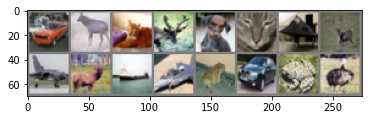

In [82]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
unnormalize_and_show(torchvision.utils.make_grid(images))

In [ ]:
class GroupEquivariantNN(nn.Module):
    
    